In [22]:
import torch

if torch.cuda.is_available():
    device_id = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(device_id)
    print(f"GPU Name: {props.name}")
    print(f"SM Count (Multi-Processor Count): {props.multi_processor_count}")
    print(f"Total Memory: {props.total_memory / 1024**3:.2f} GB")
    print(f"Compute Capability: {props.major}.{props.minor}")    
else:
    print("No GPU available")

GPU Name: Tesla T4
SM Count (Multi-Processor Count): 40
Total Memory: 14.74 GB
Compute Capability: 7.5


In [16]:
import torch
import triton 
import triton.language as tl

DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}")
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [18]:
# step1 
def native_softmax(x):
    # assume the input size (M, N)
    x_max = x.max(dim=1)[0] # shape (M)
    # print(x_max, x_max[:, None])
    z = x - x_max[:,None]
    # print(z)
    numerator = torch.exp(z)
    denominator = numerator.sum(dim=1)
    output = numerator / denominator[:, None]
    return output



x = torch.Tensor([[1, 2, 3], [6,5,4]])
native_softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.6652, 0.2447, 0.0900]])

In [17]:
@triton.jit
def _softmax_kernel(
    input_ptr, output_ptr,
    input_row_stride, output_row_stride, # number of elements to skip when moving to next row
    n_rows, n_cols,
    BLOCK_SIZE: tl.constexpr,
    num_stages: tl.constexpr,
):
    row_start = tl.program_id(0)
    # get the total number of parallel programs
    row_step = tl.num_programs(0)   

    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        row_start_ptr = input_ptr + row_idx * input_row_stride
        col_offsets = tl.arange(0, BLOCK_SIZE)
        # tl.static_print(f'col_offsets {col_offsets}')
        input_ptrs = row_start_ptr + col_offsets
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=float('-inf'))
        row_safe = row - tl.max(row, axis=0)
        numerator = tl.exp(row_safe)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator/denominator

        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        tl.store(output_row_start_ptr + col_offsets, softmax_output, mask=mask)

In [19]:
# step3
properties = triton.runtime.driver.active.utils.get_device_properties(DEVICE.index)
# print(properties)
NUM_SM = properties['multiprocessor_count']
NUM_REGS = properties['max_num_regs']
TOTAL_SRAM_PER_SM = properties['max_shared_mem']
WARP_SIZE = properties['warpSize']

def softmax(x):
    assert x.ndim == 2, "x must be a 2D tensor"
    n_rows, n_cols = x.shape
    print(n_rows, n_cols, x.shape)
    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    print(BLOCK_SIZE)
    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    num_stages = 4 if TOTAL_SRAM_PER_SM > 200_000 else 2

    y = torch.empty_like(x)

    kernel = _softmax_kernel.warmup(
        x, y,
        x.stride(0), y.stride(0),
        n_rows, n_cols,
        BLOCK_SIZE = BLOCK_SIZE,
        num_stages = num_stages,
        num_warps = num_warps,
        grid=(1,)   
    )
    kernel._init_handles()
    n_regs = kernel.n_regs
    sram_needed_per_program = kernel.metadata.shared

    reg_occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    if sram_needed_per_program == 0:
        sram_occupancy = float('inf')
    else:
        sram_occupancy = TOTAL_SRAM_PER_SM // sram_needed_per_program
    programs_per_sm = min(reg_occupancy, sram_occupancy) if sram_occupancy != float('inf') else reg_occupancy

    num_programs = min(NUM_SM * programs_per_sm, n_rows)
    grid = (num_programs, 1, 1)

    kernel[grid](
        x,y,
        x.stride(0), y.stride(0),
        n_rows, n_cols,
        BLOCK_SIZE,
        num_stages
    )
    return y
    
x = torch.randn(2, 5, device=DEVICE)
softmax(x)

2 5 torch.Size([2, 5])
8


tensor([[0.0647, 0.1679, 0.5856, 0.0586, 0.1232],
        [0.0734, 0.5203, 0.1094, 0.1664, 0.1305]], device='cuda:0')

In [20]:
# step2 
def test_softmax_kernel(size: tuple, atol=1e-3, rtol=1e-3, device=DEVICE):
    assert type(size) is tuple and len(size) == 2, "size must be a tuple of (M, N)"
    torch.manual_seed(0)
    x = torch.randn(size[0], size[1], device=device)
    z_tri = softmax(x)
    z_ref = torch.softmax(x, dim=1)
    torch.testing.assert_close(z_tri, z_ref, atol=atol, rtol=rtol)
    print('Pass')

4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4096 256 torch.Size([4096, 256])
256
4

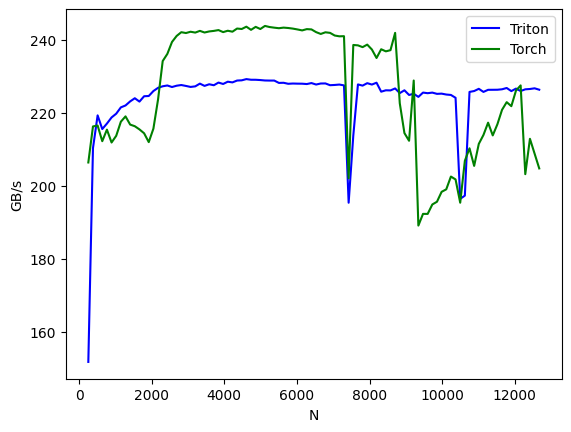

In [21]:
# step benchmark

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(2, 100)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=["Triton", "Torch"],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="softmax-performance",
        args={'M': 4096} # values for function arguments not in x_names
    )
)

def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)

    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)

    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)

benchmark.run(print_data=False)